In [11]:
%reset
%matplotlib inline

import numpy as np
from pylab import *
from matplotlib import gridspec
from matplotlib import pyplot as plt

import scipy.ndimage
import mSMOOTH

from scipy import signal

import subprocess as sp

In [12]:
# Fixed Gaussian broadening with "sigma" as input
def Gaussian(xin,yin,fwhm):    
    #fwhm = sigma * 2.3548200450309493    
    delta = xin[1]-xin[0]

    xin=np.array(xin)
    yin=np.array(yin)
    
    xout = xin
    yout = xin*0
    
    term1 = ( delta/( np.sqrt(2*3.14159265359) * (fwhm/2.3548200450309493)) )
    term2 = (-2*(fwhm/2.3548200450309493)**2)   
    
    for i in range(len(xin)):
        for j in range(len(xin)):
            yout[i]=yout[i]+yin[j]*term1*np.exp ( ((xin[i]-xin[j])**2)/term2 )
            
    return xout, yout

# Fixed Lorentzian broadening with "gamma" as input
def Lorentzian(xin,yin,gamma):    
 
    delta = xin[1]-xin[0]

    xin=np.array(xin)
    yin=np.array(yin)
    
    xout = xin
    yout = xin*0
    for i in range(len(xin)):
        for j in range(len(xin)):
            yout[j]=yout[j]+yin[i]/3.14159265359*(np.arctan((xin[i]-xin[j]+delta)/gamma)-(np.arctan((xin[i]-xin[j]-delta)/gamma)))
    
    yout = yout/2
            
    return xout, yout



class conv:
    '''
    Does convolution with Gaussian or Lorentzian
    '''
    
    def __init__(self, datax,datay,N=None):
        
        self.datax = datax
        self.datay = datay
        if N is None:
            self.NPoints = len(datax)
            self.X = np.array(datax)
        else:
            self.NPoints = N        
            self.X = np.linspace(self.datax[0], self.datax[-1], self.NPoints,endpoint=True)
        
    def Gaussian(self,sigma=None,fwhm=None,saveto=None):
        
        if fwhm:
            if sigma:
                print('ignoring input sigma')
        elif sigma:
            fwhm = sigma * np.sqrt(8 * np.log(2))
        else: 
            raise ValueError('sigma/fwhm was not set....')  
           
        self.fwhm  = fwhm 
        self.sigma = fwhm/np.sqrt(8 * np.log(2))         
        
        out = np.zeros(self.NPoints)
        math1 = (1 / (np.sqrt(2*np.pi)) / self.sigma)
        math2 = (2*((self.sigma)**2))
                
        for x0, y0 in zip(self.datax,self.datay):
            out += math1 * np.exp(-(self.X - x0)**2 / math2 ) * y0
            
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"                
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )       
            
        return [self.X, out]
    
        
    def Lorentzian(self,fwhm=None,gamma=None,saveto=None,fmt=None):
        # in Lorentzian fwhm is equal to gamma
        
        if fwhm:
            if gamma:
                print('in Lorentzian fwhm is equal to gamma')
        elif gamma:
            fwhm = gamma
        else: 
            raise ValueError('sigma/fwhm was not set....')  
            
        self.gamma = fwhm
        
        out = np.zeros(self.NPoints)
                
        for x0, y0 in zip(self.datax,self.datay):
            out += self.gamma / 2. / np.pi / ((self.X - x0)**2 + 0.25 * self.gamma ** 2) * y0
            
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"                
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )           
            
        return [self.X, out]    

    
        
    def LorentzianV(self,saveto=None,fmt=None):
        # in Lorentzian fwhm is equal to gamma
        
      
        m=0.1
        n=0.1
        o=self.datax[0]
        b=4
        
        gammas = []    
        for i,d in enumerate(self.datax):
            g = max(0,m*(d-o-b)) + n
            gammas.append(g)
        
        out = np.zeros(self.NPoints)
                
        for g, x0, y0 in zip(gammas,self.datax,self.datay):
            out += g / 2. / np.pi / ((self.X - x0)**2 + 0.25 * g ** 2) * y0
            
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"                
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )           
            
        return [self.X, out], [self.datax, gammas]     
    
    

In [13]:
# out = np.loadtxt('toy.dat', unpack=True, comments='#', skiprows=0)
out =  [[-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 0.,  0.,  0.,  0.,  0., 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.]]

3.00000000386
3.0
24.7499965967


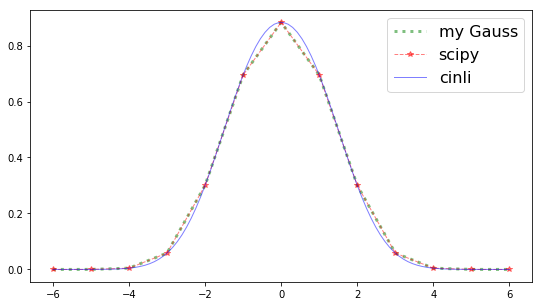

In [14]:
fig = plt.figure(figsize=(9,5))

ax = fig.add_subplot('111')


x1,y1 = Gaussian(out[0],out[1],2.3548200450309493*1)
ax.plot(x1,y1, 'g:', lw=3, alpha=0.5, label='my Gauss')
print(sum(y1))


xs,ys = x1, scipy.ndimage.gaussian_filter(out[1],1)
ax.plot(xs,ys, 'r*--', lw=1, alpha=0.5, label='scipy')
print(sum(ys))


x2,y2 = conv(out[0],out[1],100).Gaussian(sigma=1) 
ax.plot(x2,y2, 'b-', lw=1, alpha=0.5, label='cinli')
print(sum(y2))


ax.legend(loc='best',fontsize=16,ncol=1)


UnboundLocalError: local variable 'fmt' referenced before assignment

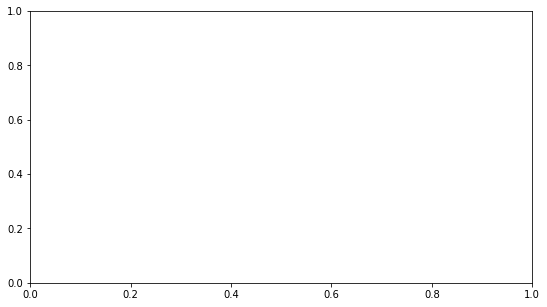

In [15]:
fig = plt.figure(figsize=(9,5))

ax = fig.add_subplot('111')


# x1,y1 = Lorentzian(out[0],out[1],1)
# ax.plot(x1,y1, 'g:', lw=3, alpha=0.5, label='my Lorentz')
# print(sum(y1))

x1,y1 = conv(out[0],out[1],100).Gaussian(fwhm=1,saveto='G.dat') 
ax.plot(x1,y1, 'rd-', lw=1, alpha=0.5, label='G')
print(sum(y1))


x2,y2 = conv(out[0],out[1],100).Lorentzian(fwhm=1,saveto='L.dat') 
ax.plot(x2,y2, 'bv--', lw=1, alpha=0.5, label='L')
print(sum(y2))

# x1,y1 = Lorentzian(out[0],out[1],11)
# ax.plot(x1,y1, 'go:', lw=3, alpha=0.5, label='my Lorentz')
# print(sum(y1))

# import mSMOOTH
# out = np.loadtxt('toy.dat', unpack=True, comments='#', skiprows=0)
# x1,y1 = mSMOOTH.Lorentzian(out[0],out[1],gamma=1/2.35)
# ax.plot(x1,y1, 'go:', lw=3, alpha=0.5, label='my Lorentz')


ax.legend(loc='best',fontsize=16,ncol=1)


In [74]:
# [x2,y2], [dx,gy] = conv(out[0],out[1],100).Lorentzian(fwhm=1) 
x2,y2 = conv(out[0],out[1],100).Lorentzian(fwhm=0.6) 

<IPython.core.display.Javascript object>


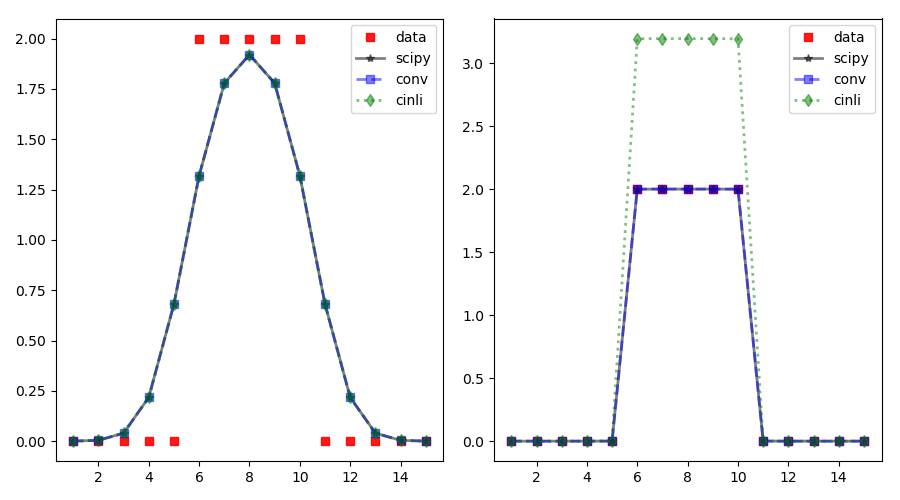

10.0
10.0
9.99998692324
10.0
10.0
15.9683976341


In [77]:
dy = np.repeat([0., 2., 0.], 5)
dx = np.linspace(1,15,15)




fig = plt.figure(figsize=(9,5))



ax = fig.add_subplot('121')
ax.plot(dx,dy, 'rs', lw=1, alpha=0.9, label='data')


xs,ys = dx, scipy.ndimage.gaussian_filter(dy,1.25)
ax.plot(xs,ys, 'k*-', lw=2, alpha=0.5, label='scipy')
print(sum(ys))

win = signal.gaussian(11,1.25)
xc, yc = dx, signal.convolve(dy, win, mode='same') / sum(win)
ax.plot(xc,yc, 'bs--', lw=2, alpha=0.5, label='conv')
print(sum(ys))

x1,y1 = conv(dx,dy).Gaussian(sigma=1.25)
ax.plot(x1,y1, 'gd:', lw=2, alpha=0.5, label='cinli')
print(sum(y1))

fig.tight_layout()
ax.legend(loc='best',fontsize=10,ncol=1)



ax = fig.add_subplot('122')
ax.plot(dx,dy, 'rs', lw=1, alpha=0.9, label='data')


xs,ys = dx, scipy.ndimage.gaussian_filter(dy,0.25)
ax.plot(xs,ys, 'k*-', lw=2, alpha=0.5, label='scipy')
print(sum(ys))

win = signal.gaussian(11,0.25)
xc, yc = dx, signal.convolve(dy, win, mode='same') / sum(win)
ax.plot(xc,yc, 'bs--', lw=2, alpha=0.5, label='conv')
print(sum(ys))

x1,y1 = conv(dx,dy).Gaussian(sigma=0.25)
ax.plot(x1,y1, 'gd:', lw=2, alpha=0.5, label='cinli')
print(sum(y1))

fig.tight_layout()
ax.legend(loc='best',fontsize=10,ncol=1)

## <span class="mark">Understand window</span>

<IPython.core.display.Javascript object>


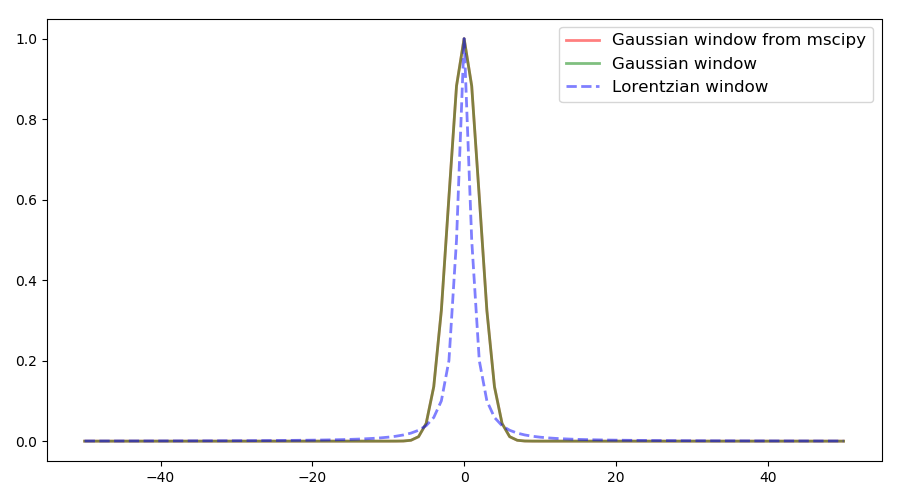

In [78]:
fig = plt.figure(figsize=(9,5))



def win_gaussian(M, sigma):
    ''' see : https://github.com/scipy/scipy/blob/v0.19.0/scipy/signal/windows.py#L1159-L1219
    M should be odd number'''
    if sigma <=0 : sigma = 0.00001
    n = np.arange(0, M) - (M - 1.0) / 2.0
    sigma2 = 2 * sigma * sigma
    w = np.exp(-n ** 2 / sigma2)    
    return w

def win_lorentzian(M, gamma):
    ''' '''
    if gamma <=0 : gamma = 0.00001
    fwhm = gamma
    n = np.arange(0, M) - (M - 1.0) / 2.0
    w = 1 / ( ((2*n)/fwhm)**2 + 1  )    
    return w




ax = fig.add_subplot('111')
M = 101
n = np.arange(0, M) - (M - 1.0) / 2.0

ws = signal.gaussian(M,2)
wg = win_gaussian(M, 2)
ax.plot(n,ws, 'r', lw=2, alpha=0.5, label='Gaussian window from mscipy')
ax.plot(n,wg, 'g-', lw=2, alpha=0.5, label='Gaussian window')


wl = win_lorentzian(M, 2)
ax.plot(n,wl, 'b--', lw=2, alpha=0.5, label='Lorentzian window')


fig.tight_layout()
ax.legend(loc='best',fontsize=12,ncol=1)

<IPython.core.display.Javascript object>


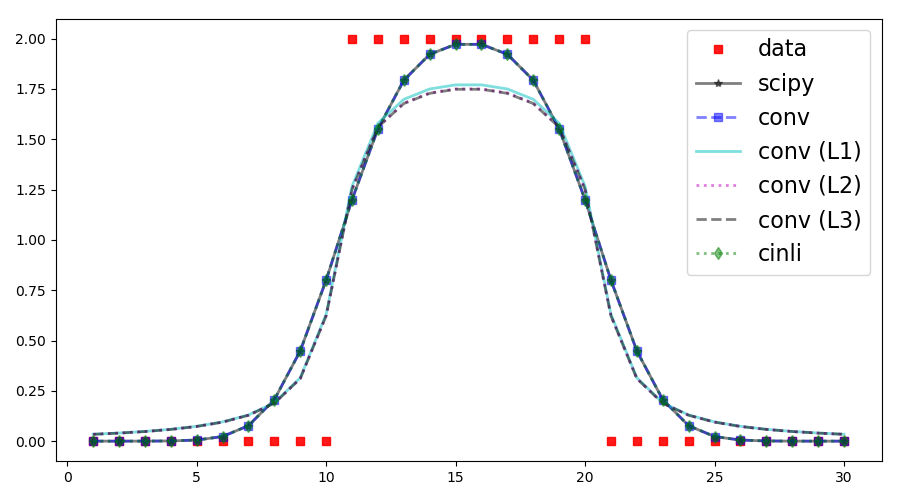

20.0
19.9999997586
19.3662956049
19.147371505
19.1255333205
19.9999997586


In [79]:
dy = np.repeat([0., 2., 0.], 10)
dx = np.linspace(1,30,30)




fig = plt.figure(figsize=(9,5))



ax = fig.add_subplot('111')
ax.plot(dx,dy, 'rs', lw=1, alpha=0.9, label='data')


xs,ys = dx, scipy.ndimage.gaussian_filter(dy,2)
ax.plot(xs,ys, 'k*-', lw=2, alpha=0.5, label='scipy')
print(sum(ys))


win = w_gaussian(101, 2)
xg, yg = dx, signal.convolve(dy, win, mode='same') / sum(win)
ax.plot(xg,yg, 'bs--', lw=2, alpha=0.5, label='conv')
print(sum(yg))


win = w_lorentzian(101, 2)
xl, yl = dx, signal.convolve(dy, win, mode='same') / sum(win)
ax.plot(xl,yl, 'c-', lw=2, alpha=0.5, label='conv (L1)')
print(sum(yl))
win = w_lorentzian(1001, 2)
xl, yl = dx, signal.convolve(dy, win, mode='same') / sum(win)
ax.plot(xl,yl, 'm:', lw=2, alpha=0.5, label='conv (L2)')
print(sum(yl))
win = w_lorentzian(10001, 2)
xl, yl = dx, signal.convolve(dy, win, mode='same') / sum(win)
ax.plot(xl,yl, 'k--', lw=2, alpha=0.5, label='conv (L3)')
print(sum(yl))

x1,y1 = conv(dx,dy).Gaussian(sigma=2)
ax.plot(x1,y1, 'gd:', lw=2, alpha=0.5, label='cinli')
print(sum(y1))





fig.tight_layout()
ax.legend(loc='best',fontsize=16,ncol=1)

In [16]:
class mconv:
    '''
    Does convolution with Gaussian or Lorentzian windows
    '''
    
    def __init__(self, datax, datay):
        
        self.datax = datax
        self.datay = datay

        self.NPoints = len(datax)
        self.X = np.array(datax)


            
    def w_gaussian(self, M, wsigma, dx):
        ''' see : https://github.com/scipy/scipy/blob/v0.19.0/scipy/signal/windows.py#L1159-L1219
        M should be odd number'''
        if wsigma <=0 : wsigma = 0.00001
        wsigma = wsigma/dx
        n = np.arange(0, M) - (M - 1.0) / 2.0
        wsigma2 = 2 * wsigma * wsigma
        wg = np.exp(-n ** 2 / wsigma2)    
        return wg

    def w_lorentzian(self, M, wgamma, dx):
        ''' '''
        wgamma = wgamma/dx
        if wgamma <=0 : wgamma = 0.00001
        n = np.arange(0, M) - (M - 1.0) / 2.0
        wl = 1 / ( ((2*n)/wgamma)**2 + 1  )    
        return wl             
           
        
    def Gaussian(self,sigma=None,fwhm=None,saveto=None):
        
        if fwhm:
            if sigma:
                print('ignoring input sigma')
        elif sigma:
            fwhm = sigma * np.sqrt(8 * np.log(2))
        else: 
            raise ValueError('sigma/fwhm was not set....')  
           
        self.sigma = fwhm/np.sqrt(8 * np.log(2))   
        
        M=101
        dx=self.datax[2]-self.datax[1]
        win = self.w_gaussian(M, self.sigma, dx)
        out = signal.convolve(self.datay, win, mode='same') / sum(win)

            
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"                
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )       
            
        return [self.X, out]
            
            
            
            
            
        
    def Lorentzian(self,gamma=None,fwhm=None,saveto=None,M=None):
        # in Lorentzian fwhm is equal to gamma
        
        if fwhm:
            if gamma:
                print('in Lorentzian fwhm is equal to gamma')
        elif gamma:
            fwhm = gamma
        else: 
            raise ValueError('sigma/fwhm was not set....')   
            
        self.gamma = fwhm 
        
        if M is None: M=1001
        dx=self.datax[2]-self.datax[1]    
        win = self.w_lorentzian(M, self.gamma, dx)
        out = signal.convolve(self.datay, win, mode='same') / sum(win)

            
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"                
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )       
            
        return [self.X, out]    
    
    
    
    
    def LorentzianVL(self,saveto=None,fmt=None,M=None,A=None,B=None,offset=None):
        # gamma = A(x-offset) + B   
        
        if A is None: A=0.1
        if B is None: B=0           
        if offset is None: offset=self.datax[0]  
        
        gammas = []    
        for i,d in enumerate(self.datax):
            g = max(0,A*(d-offset)) + B
            gammas.append(g)
  
        if M is None: M=1001   
        dx=self.datax[2]-self.datax[1]
        out = np.zeros(self.NPoints)
        
                
        for i, [gg, x0, y0] in enumerate(zip(gammas,self.datax,self.datay)):
            win = self.w_lorentzian(M, gg, dx)
            c = signal.convolve(self.datay, win, mode='same') / sum(win)
            out[i] = c[i]
                        
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"                
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )           
            
        return [self.X, out], [self.datax, gammas]      
    
    
 

2.99999974674
3.0
24.7499653295
2.99999974649
11.968268412
3.0
24.74997586
3.0


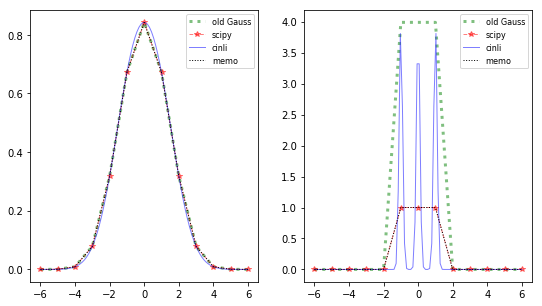

In [17]:
# out = np.loadtxt('toy.dat', unpack=True, comments='#', skiprows=0)
out =  [[-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 0.,  0.,  0.,  0.,  0., 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.]]

fig = plt.figure(figsize=(9,5))





sigma=1.1

ax = fig.add_subplot('121')

x1,y1 = Gaussian(out[0],out[1],2.3548200450309493*sigma)
ax.plot(x1,y1, 'g:', lw=3, alpha=0.5, label='old Gauss')
print(sum(y1))


xs,ys = x1, scipy.ndimage.gaussian_filter(out[1],sigma)
ax.plot(xs,ys, 'r*--', lw=1, alpha=0.5, label='scipy')
print(sum(ys))


x2,y2 = conv(out[0],out[1],100).Gaussian(sigma=sigma) 
ax.plot(x2,y2, 'b-', lw=1, alpha=0.5, label='cinli')
print(sum(y2))


x2,y2 = mconv(out[0],out[1]).Gaussian(sigma=sigma) 
ax.plot(x2,y2, 'k:', lw=1, alpha=1, label='memo')
print(sum(y2))

ax.legend(loc='best',fontsize=8,ncol=1)






sigma=0.1

ax = fig.add_subplot('122')

x1,y1 = Gaussian(out[0],out[1],2.3548200450309493*sigma)
ax.plot(x1,y1, 'g:', lw=3, alpha=0.5, label='old Gauss')
print(sum(y1))


xs,ys = x1, scipy.ndimage.gaussian_filter(out[1],sigma)
ax.plot(xs,ys, 'r*--', lw=1, alpha=0.5, label='scipy')
print(sum(ys))


x2,y2 = conv(out[0],out[1],100).Gaussian(sigma=sigma) 
ax.plot(x2,y2, 'b-', lw=1, alpha=0.5, label='cinli')
print(sum(y2))


x2,y2 = mconv(out[0],out[1]).Gaussian(sigma=sigma) 
ax.plot(x2,y2, 'k:', lw=1, alpha=1, label='memo')
print(sum(y2))

ax.legend(loc='best',fontsize=8,ncol=1)



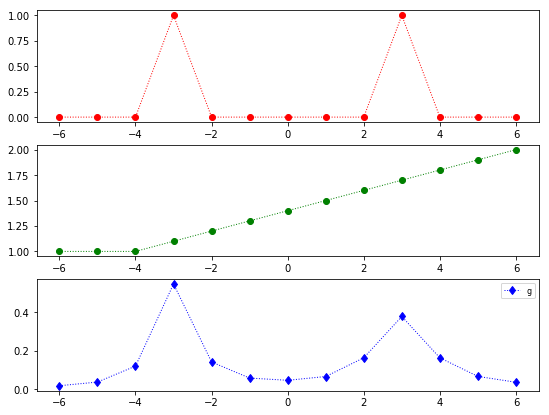

In [19]:
# out = np.loadtxt('toy.dat', unpack=True, comments='#', skiprows=0)
out =  [[-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 0.,  0.,  0.,  1.,  0., 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]]


fig = plt.figure(figsize=(9,7))



[x2,y2], [tx, gs]  = mconv(out[0],out[1]).LorentzianVL(offset=-4,A=0.1,B=1) 

ax = fig.add_subplot('311')
ax.plot(out[0],out[1], 'ro:', lw=1, alpha=1)

ax = fig.add_subplot('312')
ax.plot(tx, gs, 'go:', lw=1, alpha=1, label='g')

ax = fig.add_subplot('313')
ax.plot(x2,y2, 'bd:', lw=1, alpha=1, label='g')


ax.legend(loc='best',fontsize=8,ncol=1)

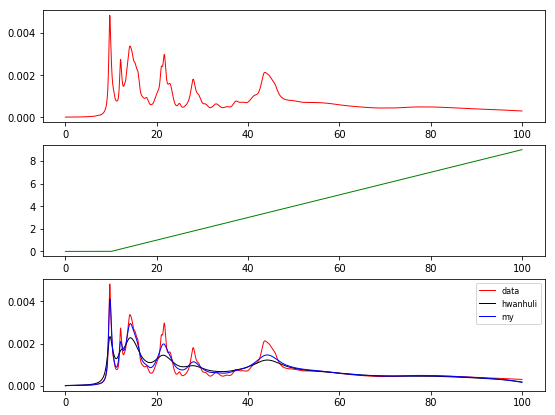

In [22]:
out = np.loadtxt('./STO/STO.csv', unpack=True, comments='#', skiprows=0)


fig = plt.figure(figsize=(9,7))

h = np.loadtxt('./STO/hwanhui.txt', unpack=True, comments='#', skiprows=0)


[x1,y1]            = mconv(out[0],out[1]).Lorentzian(gamma=-1)
[x2,y2]            = mconv(x1,y1).Gaussian(sigma=0.15)
[x3,y3], [tx, gs]  = mconv(x2,y2).LorentzianVL(offset=10,A=0.1,B=0) 

ax = fig.add_subplot('311')
ax.plot(out[0],out[1], 'r', lw=1, alpha=1)

ax = fig.add_subplot('312')
ax.plot(tx, gs, 'g', lw=1, alpha=1, label='gamma')

ax = fig.add_subplot('313')
ax.plot(out[0],out[1], 'r', lw=1, alpha=1, label='data')
ax.plot(h[0],h[1], '-k', lw=1, alpha=1, label='hwanhuli')
ax.plot(x3,y3, 'b', lw=1, alpha=1, label='my')



ax.legend(loc='best',fontsize=8,ncol=1)